# Search engine images model

This notebook is aimed at training a model on the UCLA dataset without using visual attributes as an auxiarly task, but rather search engine images. In other words, the network will have three tasks. Predict protests, the violence ranking and a binary "violence" vs "non-violence" task for the search engine images

In [9]:
import sys
sys.path.append("../")
from protestDB import cursor
import time
from protestDB import models
from lib import analysis_utils as au
import pandas as pd
import os
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import scipy
from keras import backend as Kbackend
from keras import callbacks as Kcallbacks
from keras import optimizers as Koptimizers
from keras import losses as Klosses
from keras import models as Kmodels
from keras import backend as Kbackend
from keras import applications as Kapplications
from keras import layers as Klayers
import h5py
import itertools
from lib import transforms

### Loading images

In [121]:
# loading up the images
pc = cursor.ProtestCursor()
UCLA_imgs = pc.getLabelledImagesAndNonProtest(source="UCLA", label_source="UCLA original")
google_imgs = pc.getLabelledImagesAndNonProtest(source = "google", label_source= None)
bing_imgs = pc.getLabelledImagesAndNonProtest(source = "bing", label_source= None)
search_engine_imgs = bing_imgs.append(google_imgs)

In [61]:
# asserts that the counts match
assert len(bing_imgs) == len(bing_imgs[bing_imgs['source'] == 'bing']), print("problem")
assert len(google_imgs) == len(google_imgs[google_imgs['source'] == 'google']), print("problem")

## asserts that all images have labels
assert len(bing_imgs[bing_imgs['label'] == 0.0]) + len(bing_imgs[bing_imgs['label'] == 1.0]) == len(bing_imgs), print("problem")
assert len(google_imgs[google_imgs['label'] == 0.0]) + len(google_imgs[google_imgs['label'] == 1.0]) == len(google_imgs), print("problem")

In [46]:
# asserts that we have all images on drive
images_at_time = 200
search_engine_images_test = au.ResizeSequence(
    search_engine_imgs,
    images_at_time,
    image_dir = "../../images/",
    transforms = [
        transforms.resize,
        transforms.centerCrop,
        transforms.normalizeMinMax,
        transforms.normalizeStandardScore
    ]
)

images_read = 0

for img in search_engine_images_test:
    images_read += images_at_time
    if (images_read > len(search_engine_imgs)):
        print("read all images sucessfully")
        break

200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
read all images sucessfully


### Preprocessing

In [122]:
# change type of protest column to floats and remove protest labels from search engine images
search_engine_imgs['protest'] = search_engine_imgs.protest.astype(float)
search_engine_imgs['protest'] = np.nan
UCLA_imgs['protest'] = UCLA_imgs.protest.astype(float)

In [125]:


# relevant columns
cols_keep = ["name", "label", "protest"]

# reassign labels to be called binary_violence
search_engine_imgs = search_engine_imgs[cols_keep]
search_engine_imgs_renamed = search_engine_imgs.rename(index=str, columns={"label": "binary_violence"})
search_engine_imgs_renamed["violence"] = np.nan

# reassign labels to be called violence
UCLA_imgs = UCLA_imgs[cols_keep]
UCLA_imgs_renamed = UCLA_imgs.rename(columns={"label": "violence"})
UCLA_imgs_renamed["binary_violence"] = np.nan

# select relevant columns
cols = ["name", "violence", "protest", "binary_violence"]
UCLA_imgs_renamed = UCLA_imgs_renamed[cols]
search_engine_imgs_renamed = search_engine_imgs_renamed[cols]

# append both datasets
imgs = search_engine_imgs_renamed.append(UCLA_imgs_renamed)

# save indexes of where there are no violence labels
indx_non_violence = imgs['violence'].isnull()
indx_non_violence_binary = imgs['binary_violence'].isnull()
indx_non_protest = imgs['protest'].isnull()

imgs


,name,violence,protest,binary_violence
imageHASH,,,,
dcbcf8f8f0fce8e0,dcbcf8f8f0fce8e0.JPEG,NaN,NaN,1.0
6242d252d2c2d2f0,6242d252d242d2f0.JPEG,NaN,NaN,1.0
e3e34736d8884354,e3e34736d8884354.PNG,NaN,NaN,1.0
62666e7c35343c78,62666e7c35343c78.JPEG,NaN,NaN,1.0
e3c3c559d9ca5a12,e3c3c559d9ca5a12.JPEG,NaN,NaN,1.0
d8d8c8aeb4b6c6bc,d8d8c8aeb4b6c6bc.JPEG,NaN,NaN,1.0
f8f8f8f8da9a9abe,f8f8f8f8da9a9abe.JPEG,NaN,NaN,1.0
2c355b9ba6c082a4,2c355b9ba6c082a4.JPEG,NaN,NaN,1.0
defa72664ac63624,defa72664ac63624.JPEG,NaN,NaN,1.0


In [156]:
# Apply a cut point and normalize violence scores
cutpoint = 0.43

#clips
imgs_clipped = au.clipDFColumn(imgs, 'violence', cutpoint)

# normalize
imgs_clipped = au.minMax(imgs_clipped, 'violence')

# mask values 
imgs_clipped.loc[indx_non_violence, "violence"] = -1
imgs_clipped.loc[indx_non_violence_binary, "binary_violence"] = -1
imgs_clipped.loc[indx_non_protest, "protest"] = -1

df = imgs_clipped
df

,name,violence,protest,binary_violence
imageHASH,,,,
dcbcf8f8f0fce8e0,dcbcf8f8f0fce8e0.JPEG,-1.000000,-1.0,1.0
6242d252d2c2d2f0,6242d252d242d2f0.JPEG,-1.000000,-1.0,1.0
e3e34736d8884354,e3e34736d8884354.PNG,-1.000000,-1.0,1.0
62666e7c35343c78,62666e7c35343c78.JPEG,-1.000000,-1.0,1.0
e3c3c559d9ca5a12,e3c3c559d9ca5a12.JPEG,-1.000000,-1.0,1.0
d8d8c8aeb4b6c6bc,d8d8c8aeb4b6c6bc.JPEG,-1.000000,-1.0,1.0
f8f8f8f8da9a9abe,f8f8f8f8da9a9abe.JPEG,-1.000000,-1.0,1.0
2c355b9ba6c082a4,2c355b9ba6c082a4.JPEG,-1.000000,-1.0,1.0
defa72664ac63624,defa72664ac63624.JPEG,-1.000000,-1.0,1.0


In [157]:
# assert everything went fine
for indx, row in df.iterrows():
    # case when there is a binary violence value
    assert ( (row['violence'] == -1 and row['protest'] == -1 and row['binary_violence'] != -1) or
    # case when there is a non protest image without violence score
    (row['violence'] == -1 and row['protest'] == 0 and row['binary_violence'] == -1) or
    # case when there is a protest image with violence score
    (row['violence'] != -1 and row['protest'] == 1 and row['binary_violence'] == -1) ), print ("problem")

### Divide the data

In [161]:
n_folds = 5
seed = 300

In [163]:
k_folds = au.getKSplits(df, n_folds, seed)
for i in k_folds:
    print("kfold has ", len(i[i["protest"] == 1]), "protest images and ", 
          len(i[i["protest"] == 0]), "non protest images",
         len(i[i["binary_violence"] == 0]), "non violent images",
         len(i[i["binary_violence"] == 1]), "violent images")

kfold has  2301 protest images and  5864 non protest images 581 non violent images 611 violent images
kfold has  2378 protest images and  5780 non protest images 591 non violent images 608 violent images
kfold has  2319 protest images and  5816 non protest images 606 non violent images 616 violent images
kfold has  2346 protest images and  5832 non protest images 603 non violent images 576 violent images
kfold has  2302 protest images and  5782 non protest images 621 non violent images 654 violent images


In [164]:
k_folds[0]

,name,violence,protest,binary_violence
imageHASH,,,,
4ecab2ce4d4d3396,train-15038.jpg,-1.000000,0.0,-1.0
f048c8c9e9a9c8c8,f048c8c9e9a9c8c8.JPEG,-1.000000,-1.0,1.0
094b636be8d1d4f2,train-12037.jpg,-1.000000,0.0,-1.0
8d090d5d79b39296,test-06908.jpg,0.305317,1.0,-1.0
0c96b695113131f1,test-07366.jpg,-1.000000,0.0,-1.0
737575d4c4b0b8b9,test-02545.jpg,-1.000000,0.0,-1.0
9ded595232585858,test-04731.jpg,-1.000000,0.0,-1.0
96b8e0f8facaa2da,test-02007.jpg,-1.000000,0.0,-1.0
c7e7d632b3dbd7d2,train-14398.jpg,0.277295,1.0,-1.0


In [165]:
validation_df = k_folds[0].copy()
test_df = k_folds[1].copy()
train_df = k_folds[2].copy().append(k_folds[3].copy()).append(k_folds[4].copy())
print("train set has ", len(train_df) , " images. validation has ", len(validation_df), " images and test has ", len(test_df))

train set has  28073  images. validation has  9357  images and test has  9357


In [166]:
batch_size = 32

In [191]:
dummy_test_generator = au.ResizeSequence(
    train_df[np.random.randint(100):np.random.randint(100, 200)],
    batch_size,
    image_dir = "../../images",
    targets = ['protest', 'violence'],
    transforms = [
        transforms.randomResizedCrop,
        transforms.randomRotation,
        transforms.randomHorizontalFlip,
        transforms.colorJitter,
        transforms.normalizeMinMax,
        transforms.lighting,
        transforms.normalizeStandardScore
    ] 
)



In [186]:
gen = dummy_test_generator.__iter__()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


protest has shape (32,)  violence has shape (32,)


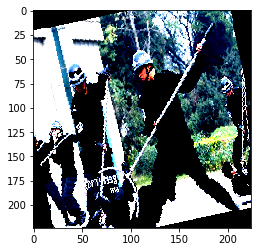

In [195]:
first = next(gen)
image = first[0][0]
protest = first[1][0]
violence = first[1][1]
img = np.array(image)
plt.imshow(img)
print("protest has shape", protest.shape, " violence has shape", violence.shape)